# Additive Noise Mechanisms

This notebook documents the variations on additive noise mechanisms in OpenDP:

* Distribution: Laplace vs. Gaussian
* Support: float vs. integer
* Domain: scalar vs. vector
* Bit-depth

----
Any constructors that have not completed the proof-writing and vetting process may still be accessed if you opt-in to "contrib".
Please contact us if you are interested in proof-writing. Thank you!

In [31]:
from opendp.mod import enable_features
enable_features("contrib")

## Distribution: Laplace vs. Gaussian

The Laplace mechanism is a ubiquitous algorithm in the DP ecosystem that is used to privatize an aggregate, like a sum or mean.

An instance of the Laplace mechanism is captured by a _measurement_ containing the following five elements:

<details>
  <summary>Elements of a Laplace Measurement</summary>

1. We first define the **function** $f(\cdot)$, that applies the Laplace mechanism to some argument $x$. This function simply samples from the Laplace distribution centered at $x$, with a fixed noise scale.

$$f(x) = Laplace(\mu=x, b=scale)$$

2. Importantly, $f(\cdot)$ is only well-defined for any finite float input. This set of permitted inputs is described by the **input domain** (denoted `AtomDomain<f64>`).

3. The Laplace mechanism has a privacy guarantee in terms of epsilon. 
This guarantee is represented by a **privacy map**, a function that computes the privacy loss $\epsilon$ for any choice of sensitivity $\Delta$.

$$map(\Delta) = \Delta / scale <= \epsilon$$

4. This map only promises that the privacy loss will be at most $\epsilon$ if inputs from any two neighboring datasets may differ by no more than some quantity $\Delta$ under the absolute distance **input metric** (`AbsoluteDistance<f64>`).

5. We similarly describe units on the output ($\epsilon$) via the **output measure** (`MaxDivergence<f64>`).
</details>


The `make_base_laplace` constructor function returns the equivalent of the Laplace measurement described above.

In [32]:
from opendp.measurements import make_base_laplace

# call the constructor to produce the measurement `base_lap`
base_lap = make_base_laplace(scale=2.)

# invoke the measurement on some aggregate x, to sample Laplace(x, 1.) noise
aggregated = 0.
print("noisy aggregate:", base_lap(aggregated))

# we must know the sensitivity of `aggregated` to determine epsilon
sensitivity = 1.
print("epsilon:", base_lap.map(d_in=sensitivity))

noisy aggregate: -3.1135951257672723
epsilon: 0.5


The analogous constructor for gaussian noise is `make_base_gaussian`: 

In [33]:
from opendp.measurements import make_base_gaussian

# call the constructor to produce the measurement `base_gauss`
base_gauss = make_base_gaussian(scale=2.)

# invoke the measurement on some aggregate x, to sample Gaussian(x, 1.) noise
aggregated = 0.
print("noisy aggregate:", base_gauss(aggregated))

# we must know the sensitivity of `aggregated` to determine epsilon
sensitivity = 1.
print("rho:", base_gauss.map(d_in=sensitivity))

noisy aggregate: -2.713640944017099
rho: 0.125


Notice that `base_lap` measures privacy with epsilon (in the `MaxDivergence` measure), and `base_gauss` measures privacy with rho (in the `ZeroConcentratedDivergence` measure).


## Support: Float vs. Integer

There are also discrete analogues of the continuous Laplace and Gaussian measurements.
The continuous measurements accept and emit floats, while the discrete measurements accept and emit integers.
Measurements with distributions supported on the integers expect integer sensitivities by default.

`make_base_discrete_laplace` is equivalent to the geometric mechanism:

In [34]:
from opendp.measurements import make_base_discrete_laplace

# call the constructor to produce the measurement `base_discrete_lap`
base_discrete_lap = make_base_discrete_laplace(scale=1.)

# invoke the measurement on some integer aggregate x, to sample DiscreteLaplace(x, 1.) noise
aggregated = 0
print("noisy aggregate:", base_discrete_lap(aggregated))

# in this case, the sensitivity is integral:
sensitivity = 1
print("epsilon:", base_discrete_lap.map(d_in=sensitivity))

noisy aggregate: 0
epsilon: 1.0


`make_base_discrete_gaussian` is the analogous measurement for Gaussian noise:

In [35]:
from opendp.measurements import make_base_discrete_gaussian

# call the constructor to produce the measurement `base_discrete_gauss`
base_discrete_gauss = make_base_discrete_gaussian(scale=1.)

# invoke the measurement on some aggregate x, to sample DiscreteGaussian(x, 1.) noise
aggregated = 0
print("noisy aggregate:", base_discrete_gauss(aggregated))

# we must know the sensitivity of `aggregated` to determine epsilon
sensitivity = 1
print("rho:", base_discrete_gauss.map(d_in=sensitivity))

noisy aggregate: -1
rho: 0.5


The continuous mechanisms use these discrete samplers internally.
More information on this can be found at the end of this notebook.

## Domain: Scalar vs. Vector

Measurements covered thus far have accepted scalar inputs and emitted scalar outputs, 
and sensitivities have been expressed in terms of the absolute distance.

All constructors have an additional argument `D` (short for "Domain"), which can be used to configure the shape of the domain that the mechanism operates over.
`D` defaults to `AtomDomain<T>`, which represents the space of all (non-null) elements of some type `T` (where `T` is `float` or `int`, depending on the support of the distribution).

You can instead set `D` to `"VectorDomain<AtomDomain<T>>"`, (where `T` is `float` or `int`) which indicates that the measurement should be vector-valued.

In [36]:
# call again, but this time indicate that the measurement should operate over a vector domain
base_lap_vec = make_base_laplace(
    scale=1., D="VectorDomain<AtomDomain<float>>"
)

aggregated = 1.
# If we try to pass the wrong data type into our vector laplace measurement, 
# the error shows that our float argument should be a vector of floats.
try:
    print("noisy aggregate:", base_lap_vec(aggregated))
except TypeError as e:
    # The error messages will often point to a discussion page with more info.
    print(e)

inferred type is f64, expected Vec<f64>. See https://github.com/opendp/opendp/discussions/298


In [37]:
# actually pass a vector-valued input, as expected
aggregated = [0., 2., 2.]
print("noisy aggregate:", base_lap_vec(aggregated))


noisy aggregate: [0.13960776943015754, 1.9918326778096607, 1.7100959620394025]


The resulting measurement expects sensitivity in terms of the appropriate Lp-distance: the vector Laplace measurement expects sensitivity in terms of an `"L1Distance<T>"`, while the vector Gaussian measurement expects a sensitivity in terms of an `"L2Distance<T>"`. 

In [38]:
sensitivity = 1.
print("epsilon:", base_lap_vec.map(d_in=sensitivity))

epsilon: 1.0


The documentation for each constructor also reflects the relationship between `D` and the resulting input metric in a table:

In [39]:
help(make_base_laplace)

Help on function make_base_laplace in module opendp.measurements:

make_base_laplace(scale, k: int = -1074, D: Union[ForwardRef('RuntimeType'), _GenericAlias, str, Type[Union[List, Tuple, int, float, str, bool]], tuple] = 'AtomDomain<T>') -> opendp.mod.Measurement
    Make a Measurement that adds noise from the laplace(`scale`) distribution to a scalar value.
    
    Set `D` to change the input data type and input metric:
    
    | `D`                          | input type   | `D::InputMetric`       |
    | ---------------------------- | ------------ | ---------------------- |
    | `AtomDomain<T>` (default)     | `T`          | `AbsoluteDistance<T>`  |
    | `VectorDomain<AtomDomain<T>>` | `Vec<T>`     | `L1Distance<T>`        |
    
    
    This function takes a noise granularity in terms of 2^k. 
    Larger granularities are more computationally efficient, but have a looser privacy map. 
    If k is not set, k defaults to the smallest granularity.
    
    [make_base_laplace in R

Regardless of the choice of `D`, the discrete versions of the measurements still expect integral sensitivities.
A special affordance is made for the vector-valued discrete Gaussian mechanism, which can be configured to expect a float sensitivity instead:

In [40]:
# call again, but this time indicate that the measurement should operate over a vector domain
base_gauss_vec = make_base_discrete_gaussian(
    scale=1., D="VectorDomain<AtomDomain<int>>", QI=float
)

base_gauss_vec.map(d_in=1.414)


0.999698

Throughout the library, types for distances are labeled with `Q` (because `D` is already taken for domains). The type argument `QI` stands for "input distance".

## Bit depth

By default, all floating-point data types default to 64-bit double-precision (denoted `"f64"`), and all integral data types default to 32-bit (denoted `"i32"`).
The atomic data type expected by the function and privacy units can be further configured to operate over specific bit-depths by explicitly specifying `"f32"` instead of `"float"`, or `"i64"` instead of `"int"`. 

In [41]:
# explicitly specify that the...
# * computation should be handled with 32-bit integers, and the
# * privacy analysis be conducted with 64-bit floats
base_discrete_lap_i32 = make_base_discrete_laplace(
    scale=1., D="AtomDomain<i32>", QO="f64"
)

More information on acceptable data types can be found in the _Utilities > Typing_ section of the User Guide.

## Desideratum: Floating-Point Granularity

The "continuous" Laplace and Gaussian measurements convert their float arguments to a rational representation, and then add integer noise to the numerator via the respective discrete distribution. 
In the OpenDP Library's default configuration, this rational representation of a float is exact.
Therefore the privacy analysis is as tight as if you were to sample truly continuous noise and then postprocess by rounding to the nearest float. 

For most use-cases the sampling algorithm is sufficiently fast when the rational representation is exact.
That is, when noise is sampled with a granularity of $2^{-1074}$, the same granularity as the distance between subnormal 64-bit floats.
However, the granularity can be adjusted to $2^k$, for some choice of k, for a faster runtime.
Adjusting this parameter comes with a small penalty to the sensitivity (to account for rounding to the nearest rational), and subsequently, to the privacy parameters.

The following plot shows the resulting distribution for some large choices of k:

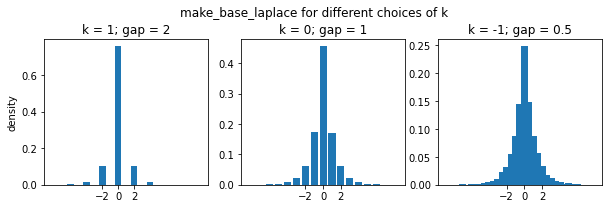

In [42]:
import numpy as np
import matplotlib.pyplot as plt

num_samples = 10_000
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
fig.subplots_adjust(top=0.8)
for axis, k in zip(axes, [1, 0, -1]):
    base_lap_vec = make_base_laplace(1., k=k, D="VectorDomain<AtomDomain<float>>")
    support, counts = np.unique(base_lap_vec([0.] * num_samples), return_counts=True)
    axis.bar(support, counts / num_samples)
    axis.set_xticks([-2, 0, 2])
    axis.set_title(f"k = {k}; gap = {2**k}")
axes[0].set_ylabel("density")
fig.suptitle('make_base_laplace for different choices of k', y=0.95);

The distribution becomes increasingly smooth as k approaches the default value (`-1074`).

The privacy map still adds a penalization when the sensitivity is zero. 
The following table uses this behavior to show the increase in epsilon for some choices of k:

In [50]:
k = [-1074, -1073, -100, -1, 0, 1]
ε_penalty = [make_base_laplace(scale=1., k=k_i).map(d_in=0.) for k_i in k]
detail = ["no penalty", "~min float", "~2^-100", "~2^-1", "~2^0", "~2^1"]

import pandas as pd
pd.DataFrame({"k": k, "ε penalty": ε_penalty, "detail": detail}).set_index("k")

,ε penalty,detail
k,,
-1074,0.000000e+00,no penalty
-1073,4.940656e-324,~min float
-100,7.888609e-31,~2^-100
-1,5.000000e-01,~2^-1
0,1.000000e+00,~2^0
1,2.000000e+00,~2^1
